In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('boston311_final.csv')

In [3]:
df.shape

(77881, 27)

In [3]:
df.head()

,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,reason,...,neighborhood_services_district,precinct,location_zipcode,latitude,longitude,source,ward_number,queue_name,open_date,closed_date
0,101005402776,2024-04-08 11:09:17,NaN,2024-04-08 13:30:46,ONTIME,Closed,Case Closed. Closed date : Mon Apr 08 17:30:46...,Needle Pickup,Mayor's 24 Hour Hotline,Needle Program,...,5.0,0601,2127,42.342090,-71.056360,Citizens Connect App,6,Needle,2024-04-08,2024-04-08
1,101005402777,2024-04-08 11:10:05,NaN,2024-04-08 11:38:16,ONTIME,Closed,Case Closed. Closed date : Mon Apr 08 15:38:16...,Needle Pickup,Mayor's 24 Hour Hotline,Needle Program,...,6.0,0404,0,42.341127,-71.081153,Citizens Connect App,4,Needle,2024-04-08,2024-04-08
2,101005357059,2024-03-19 06:57:55,NaN,2024-03-19 07:10:23,ONTIME,Closed,Case Closed. Closed date : Tue Mar 19 11:10:23...,Needle Pickup,Mayor's 24 Hour Hotline,Needle Program,...,6.0,0404,0,42.342563,-71.081864,Citizens Connect App,4,Needle,2024-03-19,2024-03-19
3,101005356895,2024-03-19 05:40:10,NaN,2024-03-19 05:49:12,ONTIME,Closed,Case Closed. Closed date : Tue Mar 19 09:49:12...,Needle Pickup,Mayor's 24 Hour Hotline,Needle Program,...,3.0,0306,2108,42.358549,-71.059420,Citizens Connect App,3,Needle,2024-03-19,2024-03-19
4,101005579920,2024-07-22 14:11:00,NaN,2024-07-22 14:37:14,ONTIME,Closed,Case Closed. Closed date : Mon Jul 22 18:37:14...,Needle Pickup,Mayor's 24 Hour Hotline,Needle Program,...,6.0,0901,0,42.338770,-71.074724,Citizens Connect App,9,Needle,2024-07-22,2024-07-22


In [4]:
df.dtypes

,0
case_enquiry_id,int64
open_dt,object
sla_target_dt,object
closed_dt,object
on_time,object
case_status,object
closure_reason,object
case_title,object
subject,object
reason,object


In [5]:
df['open_dt'] = pd.to_datetime(df['open_dt'], errors='coerce')
df['sla_target_dt'] = pd.to_datetime(df['sla_target_dt'], errors='coerce')
df['closed_dt'] = pd.to_datetime(df['closed_dt'], errors='coerce')
df['open_date'] = pd.to_datetime(df['open_date'], errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

In [6]:
df.columns

Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'department', 'fire_district', 'pwd_district',
       'city_council_district', 'police_district', 'neighborhood',
       'neighborhood_services_district', 'precinct', 'location_zipcode',
       'latitude', 'longitude', 'source', 'ward_number', 'queue_name',
       'open_date', 'closed_date'],
      dtype='object')

Basic idea of data model - Dummy Data Model

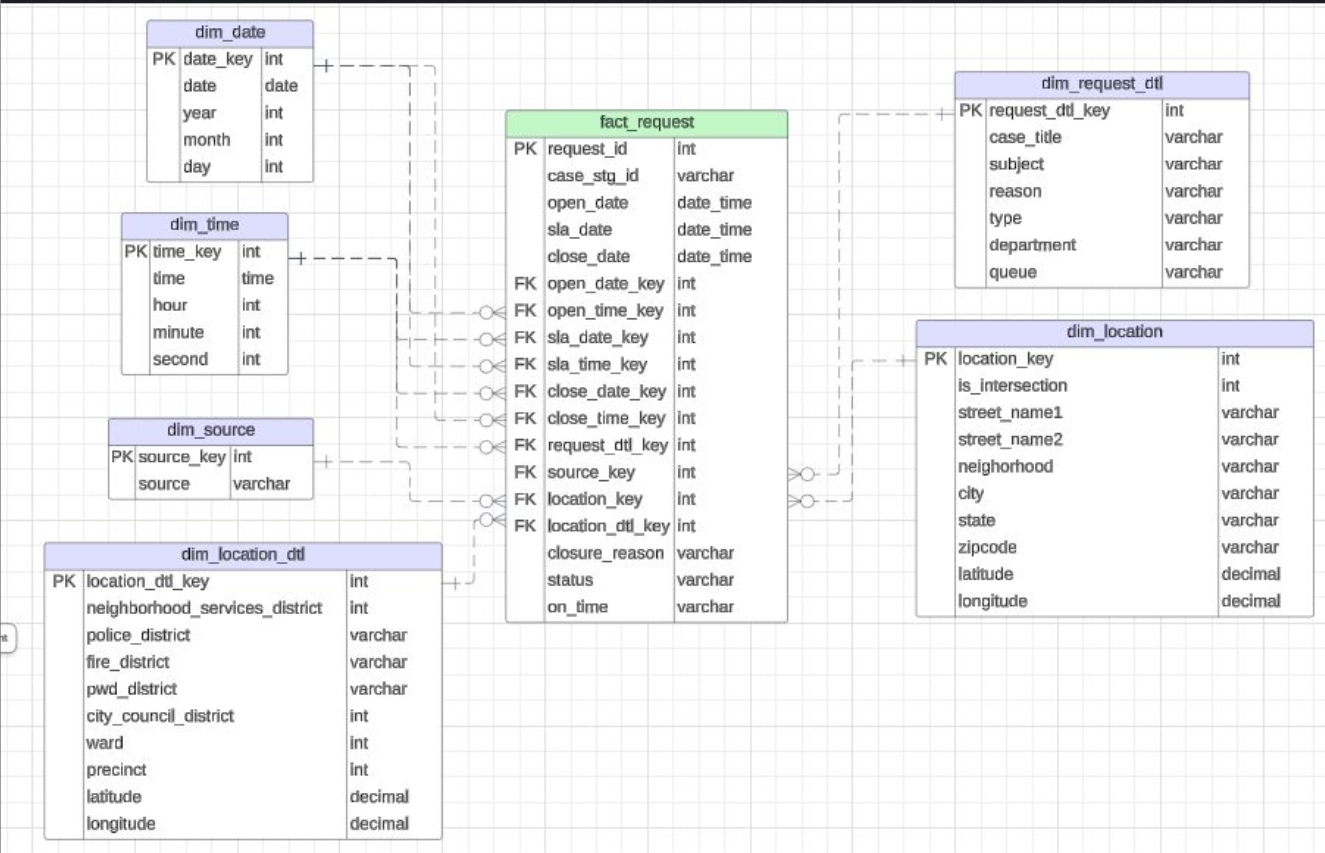

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, datediff, when
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, TimestampType, LongType # Import LongType
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyspark.sql.functions import udf
from pyspark.sql import functions as F

In [8]:
spark = SparkSession.builder \
    .appName("Boston311Analysis") \
    .getOrCreate()

In [9]:
schema = StructType([
    StructField("case_enquiry_id", LongType(), True),
    StructField("open_dt", TimestampType(), True),
    StructField("sla_target_dt", TimestampType(), True),
    StructField("closed_dt", TimestampType(), True),
    StructField("on_time", StringType(), True),
    StructField("case_status", StringType(), True),
    StructField("closure_reason", StringType(), True),
    StructField("case_title", StringType(), True),
    StructField("subject", StringType(), True),
    StructField("reason", StringType(), True),
    StructField("type", StringType(), True),
    StructField("department", StringType(), True),
    StructField("fire_district", FloatType(), True),
    StructField("pwd_district", StringType(), True),
    StructField("city_council_district", FloatType(), True),
    StructField("police_district", StringType(), True),
    StructField("neighborhood", StringType(), True),
    StructField("neighborhood_services_district", FloatType(), True),
    StructField("precinct", StringType(), True),
    StructField("location_zipcode", IntegerType(), True),
    StructField("latitude", FloatType(), True),
    StructField("longitude", FloatType(), True),
    StructField("source", StringType(), True),
    StructField("ward_number", IntegerType(), True),
    StructField("queue_name", StringType(), True),
    StructField("open_date", TimestampType(), True),
    StructField("closed_date", TimestampType(), True)
])

# Load your cleaned pandas DataFrame into PySpark
# Assuming your pandas DataFrame is called 'df'
spark_df = spark.createDataFrame(df, schema=schema)

In [10]:
spark_df = spark_df.withColumn("open_dt", to_timestamp(col("open_dt"), "yyyy-MM-dd")) \
                   .withColumn("sla_target_dt", to_timestamp(col("sla_target_dt"), "yyyy-MM-dd")) \
                   .withColumn("closed_dt", to_timestamp(col("closed_dt"), "yyyy-MM-dd"))

In [11]:
spark_df.show()

+---------------+-------------------+-------------------+-------------------+-------+-----------+--------------------+---------------+--------------------+----------------+---------------+----------+-------------+------------+---------------------+---------------+--------------------+------------------------------+--------+----------------+---------+----------+--------------------+-----------+----------------+-------------------+-------------------+
|case_enquiry_id|            open_dt|      sla_target_dt|          closed_dt|on_time|case_status|      closure_reason|     case_title|             subject|          reason|           type|department|fire_district|pwd_district|city_council_district|police_district|        neighborhood|neighborhood_services_district|precinct|location_zipcode| latitude| longitude|              source|ward_number|      queue_name|          open_date|        closed_date|
+---------------+-------------------+-------------------+-------------------+-------+-------

In [12]:
from pyspark.sql.functions import col, to_date, hour, minute, second, year, month, dayofmonth, dayofweek, monotonically_increasing_id # Import monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, LongType, TimestampType, DateType
# Create dim_date
dim_date = spark_df.select(
    to_date(col("open_dt")).alias("date"),
    year(col("open_dt")).alias("year"),
    month(col("open_dt")).alias("month"),
    dayofmonth(col("open_dt")).alias("day"),
    dayofweek(col("open_dt")).alias("weekday")
).distinct()

# Add a unique date_key
dim_date = dim_date.withColumn("date_key", monotonically_increasing_id().cast(IntegerType()))
dim_date.show(5)

+----------+----+-----+---+-------+--------+
|      date|year|month|day|weekday|date_key|
+----------+----+-----+---+-------+--------+
|2023-05-01|2023|    5|  1|      2|       0|
|2022-05-29|2022|    5| 29|      1|       1|
|2022-06-14|2022|    6| 14|      3|       2|
|2021-06-15|2021|    6| 15|      3|       3|
|2021-06-20|2021|    6| 20|      1|       4|
+----------+----+-----+---+-------+--------+
only showing top 5 rows



In [13]:
dim_date.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|              year|             month|               day|           weekday|         date_key|
+-------+------------------+------------------+------------------+------------------+-----------------+
|  count|              1873|              1873|              1873|              1873|             1873|
|   mean|2020.5616657768287| 5.933262146289375|15.558996262680193| 3.993059263214095|            936.0|
| stddev| 3.105613163473099|3.6944357682130557| 8.887284771847073|2.0019901650487215|540.8328454029643|
|    min|              2015|                 1|                 1|                 1|                0|
|    max|              2025|                12|                31|                 7|             1872|
+-------+------------------+------------------+------------------+------------------+-----------------+



In [14]:
dim_time = spark_df.select(
    hour(col("open_dt")).alias("hour"),
    minute(col("open_dt")).alias("minute"),
    second(col("open_dt")).alias("second")
).distinct()

# Add a unique time_key
dim_time = dim_time.withColumn("time_key", monotonically_increasing_id().cast(IntegerType()))
dim_time.show(5)

+----+------+------+--------+
|hour|minute|second|time_key|
+----+------+------+--------+
|   8|    16|    26|       0|
|  13|    54|    47|       1|
|   3|     8|    50|       2|
|   8|    57|    59|       3|
|   7|    52|     2|       4|
+----+------+------+--------+
only showing top 5 rows



In [15]:
dim_time.describe().show()

+-------+-----------------+------------------+------------------+-----------------+
|summary|             hour|            minute|            second|         time_key|
+-------+-----------------+------------------+------------------+-----------------+
|  count|            28929|             28929|             28929|            28929|
|   mean| 9.08873448788413|29.403712537592035|28.799301738739672|          14464.0|
| stddev|4.744739819174421|17.288751483690675| 17.71241458186708|8351.227305013317|
|    min|                0|                 0|                 0|                0|
|    max|               23|                59|                59|            28928|
+-------+-----------------+------------------+------------------+-----------------+



In [16]:
dim_source = spark_df.select(
    col("source")
).distinct()

# Add a unique source_key
dim_source = dim_source.withColumn("source_key", monotonically_increasing_id().cast(IntegerType()))
dim_source.show(5)

+--------------------+----------+
|              source|source_key|
+--------------------+----------+
|        Self Service|         0|
|  Employee Generated|         1|
|    Constituent Call|         2|
|Citizens Connect App|         3|
|     City Worker App|         4|
+--------------------+----------+
only showing top 5 rows



In [17]:
from pyspark.sql.functions import lpad,row_number
from pyspark.sql.window import Window

# Create dim_location with left-padded location_zipcode
dim_location = spark_df.select(
    col("latitude"),
    col("longitude"),
    col("neighborhood"),
    col("fire_district"),
    col("pwd_district"),
    col("city_council_district"),
    col("police_district"),
    col("neighborhood_services_district"),
    col("precinct"),
    # Left-pad location_zipcode to 5 characters with '0'
    lpad(col("location_zipcode").cast("string"), 5, "0").alias("location_zipcode"),
    col("ward_number")
).distinct()

# Step 2: Create window spec for row_number
windowSpec = Window.orderBy(
    col("latitude"), col("longitude"), col("location_zipcode")
)

# Step 3: Add unique location_key using row_number
dim_location = dim_location.withColumn("location_key", row_number().over(windowSpec))

dim_location.show(5)

+---------+----------+------------+-------------+------------+---------------------+---------------+------------------------------+--------+----------------+-----------+------------+
| latitude| longitude|neighborhood|fire_district|pwd_district|city_council_district|police_district|neighborhood_services_district|precinct|location_zipcode|ward_number|location_key|
+---------+----------+------------+-------------+------------+---------------------+---------------+------------------------------+--------+----------------+-----------+------------+
|  42.2321| -71.12963|   Hyde Park|         12.0|          08|                  5.0|            E18|                          10.0|    1820|           02136|         18|           1|
| 42.23225| -71.13001|   Hyde Park|         12.0|          08|                  5.0|            E18|                          10.0|    1820|           02136|         18|           2|
| 42.23239| -71.13046|   Hyde Park|         12.0|          08|                  5.0| 

In [18]:
dim_location.count()

38762

In [19]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

dim_request = spark_df.select(
    col("case_title"),
    col("subject"),
    col("reason"),
    col("type"),
    col("department"),
    col("queue_name"),
    col("closure_reason"),
    col("on_time")
).distinct()

# Step 2: Create window spec for row_number
windowSpec = Window.orderBy(
    col("case_title"), col("reason"), col("type"), col("department"),
)

# Step 3: Add unique request_key using row_number
dim_request = dim_request.withColumn("request_key", row_number().over(windowSpec))

dim_request.show(5)

+--------------------+--------------------+-----------------+--------------------+----------+--------------------+--------------------+-------+-----------+
|          case_title|             subject|           reason|                type|department|          queue_name|      closure_reason|on_time|request_key|
+--------------------+--------------------+-----------------+--------------------+----------+--------------------+--------------------+-------+-----------+
|   Abandoned Bicycle|Mayor's 24 Hour H...|Abandoned Bicycle|   Abandoned Bicycle|      BTDT|   Abandoned Bicycle|Case Closed. Clos...| ONTIME|          1|
|   Abandoned Bicycle|Mayor's 24 Hour H...|Abandoned Bicycle|   Abandoned Bicycle|      INFO|Reallocation From...|Case Closed. Clos...| ONTIME|          2|
|   Abandoned Bicycle|Mayor's 24 Hour H...|Abandoned Bicycle|   Abandoned Bicycle|      PWDx|Missed Trash\Recy...|Case Closed. Clos...| ONTIME|          3|
|        Animal Found|      Animal Control|    Animal Issues|   

In [20]:
dim_request.count()

76498

In [21]:
# Join with dim_date to get date_key
fact_syringe = spark_df.join(
    dim_date,
    (to_date(spark_df.open_dt) == dim_date.date) &
    (year(spark_df.open_dt) == dim_date.year) &
    (month(spark_df.open_dt) == dim_date.month) &
    (dayofmonth(spark_df.open_dt) == dim_date.day),
    "left"
).select(
    spark_df["*"],
    dim_date.date_key
)

# Join with dim_time to get time_key
fact_syringe = fact_syringe.join(
    dim_time,
    (hour(fact_syringe.open_dt) == dim_time.hour) &
    (minute(fact_syringe.open_dt) == dim_time.minute) &
    (second(fact_syringe.open_dt) == dim_time.second),
    "left"
).select(
    fact_syringe["*"],
    dim_time.time_key
)

# Join with dim_source to get source_key
fact_syringe = fact_syringe.join(
    dim_source,
    fact_syringe.source == dim_source.source,
    "left"
).select(
    fact_syringe["*"],
    dim_source.source_key
)

# Join with dim_location to get location_key
fact_syringe = fact_syringe.join(
    dim_location,
    (fact_syringe.latitude == dim_location.latitude) &
    (fact_syringe.longitude == dim_location.longitude) &
    (fact_syringe.neighborhood == dim_location.neighborhood) &
    (fact_syringe.fire_district == dim_location.fire_district) &
    (fact_syringe.pwd_district == dim_location.pwd_district) &
    (fact_syringe.city_council_district == dim_location.city_council_district) &
    (fact_syringe.police_district == dim_location.police_district) &
    (fact_syringe.neighborhood_services_district == dim_location.neighborhood_services_district) &
    (fact_syringe.precinct == dim_location.precinct) &
    (fact_syringe.location_zipcode == dim_location.location_zipcode) &
    (fact_syringe.ward_number == dim_location.ward_number),
    "left"
).select(
    fact_syringe["*"],
    dim_location.location_key
)

# Join with dim_request to get request_key
fact_syringe = fact_syringe.join(
    dim_request,
    (fact_syringe.case_title == dim_request.case_title) &
    (fact_syringe.subject == dim_request.subject) &
    (fact_syringe.reason == dim_request.reason) &
    (fact_syringe.type == dim_request.type) &
    (fact_syringe.department == dim_request.department) &
    (fact_syringe.queue_name == dim_request.queue_name) &
    (fact_syringe.closure_reason == dim_request.closure_reason) &
    (fact_syringe.on_time == dim_request.on_time),
    "left"
).select(
    fact_syringe["*"],
    dim_request.request_key
)

# Finalize fact_syringe by selecting relevant columns
fact_syringe = fact_syringe.select(
    col("case_enquiry_id").alias("syringe_id"),
    col("open_dt"),
    col("sla_target_dt"),
    col("closed_dt"),
    col("case_status"),
    col("date_key").alias("fk_date_key"),
    col("time_key").alias("fk_time_key"),
    col("location_key").alias("fk_location_key"),
    col("source_key").alias("fk_source_key"),
    col("request_key").alias("fk_request_key")
)

fact_syringe.show(5)

+------------+-------------------+-------------------+-------------------+-----------+-----------+-----------+---------------+-------------+--------------+
|  syringe_id|            open_dt|      sla_target_dt|          closed_dt|case_status|fk_date_key|fk_time_key|fk_location_key|fk_source_key|fk_request_key|
+------------+-------------------+-------------------+-------------------+-----------+-----------+-----------+---------------+-------------+--------------+
|101005402777|2024-04-08 11:10:05|               NULL|2024-04-08 11:38:16|     Closed|       1094|       7982|          28495|            3|         12825|
|101005402776|2024-04-08 11:09:17|               NULL|2024-04-08 13:30:46|     Closed|       1094|      16568|          28879|            3|          9746|
|101005579920|2024-07-22 14:11:00|               NULL|2024-07-22 14:37:14|     Closed|        488|      10666|          27707|            3|         19418|
|101005356895|2024-03-19 05:40:10|               NULL|2024-03-19

In [22]:
from pyspark.sql import SparkSession

# Initialize Spark session (if not already done)
spark = SparkSession.builder.appName("SaveToCSV").getOrCreate()

# Define the output directory (replace with your desired path)
# output_dir = "/path/to/output/directory"

# Save dim_date to CSV
dim_date.coalesce(1).write.csv("dim_date", header=True, mode="overwrite")

# Save dim_time to CSV
dim_time.coalesce(1).write.csv("dim_time", header=True, mode="overwrite")

# Save dim_source to CSV
dim_source.coalesce(1).write.csv("dim_source", header=True, mode="overwrite")

# Save dim_location to CSV
dim_location.coalesce(1).write.csv("dim_location", header=True, mode="overwrite")

# Save dim_request to CSV
dim_request.coalesce(1).write.csv("dim_request", header=True, mode="overwrite")

# Save fact_syringe to CSV
fact_syringe.coalesce(1).write.csv("fact_syringe", header=True, mode="overwrite")
